In [ ]:
!pip install keras-video-generators

In [3]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
print(os.path)
# classes = [i.split(os.path.sep)[1] for i in glob.glob('/content/drive/Shareddrives/Final Year Project/Datasets/Mini-RWF-2000/*')]
# classes.sort()
classes=["Fight","NonFight"]
print(classes)

<module 'posixpath' from '/usr/lib/python3.6/posixpath.py'>
['Fight', 'NonFight']


In [4]:

# some global params
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 5
BS = 8
# pattern to get videos and classes
glob_pattern='/content/drive/Shareddrives/Final Year Project/Datasets/Mini-RWF-2000/{classname}/*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Fight, validation count: 1, train count: 5
class NonFight, validation count: 1, train count: 5
Total data: 2 classes for 10 files for train


In [5]:
valid = train.get_validation_generator()

Total data: 2 classes for 2 files for validation


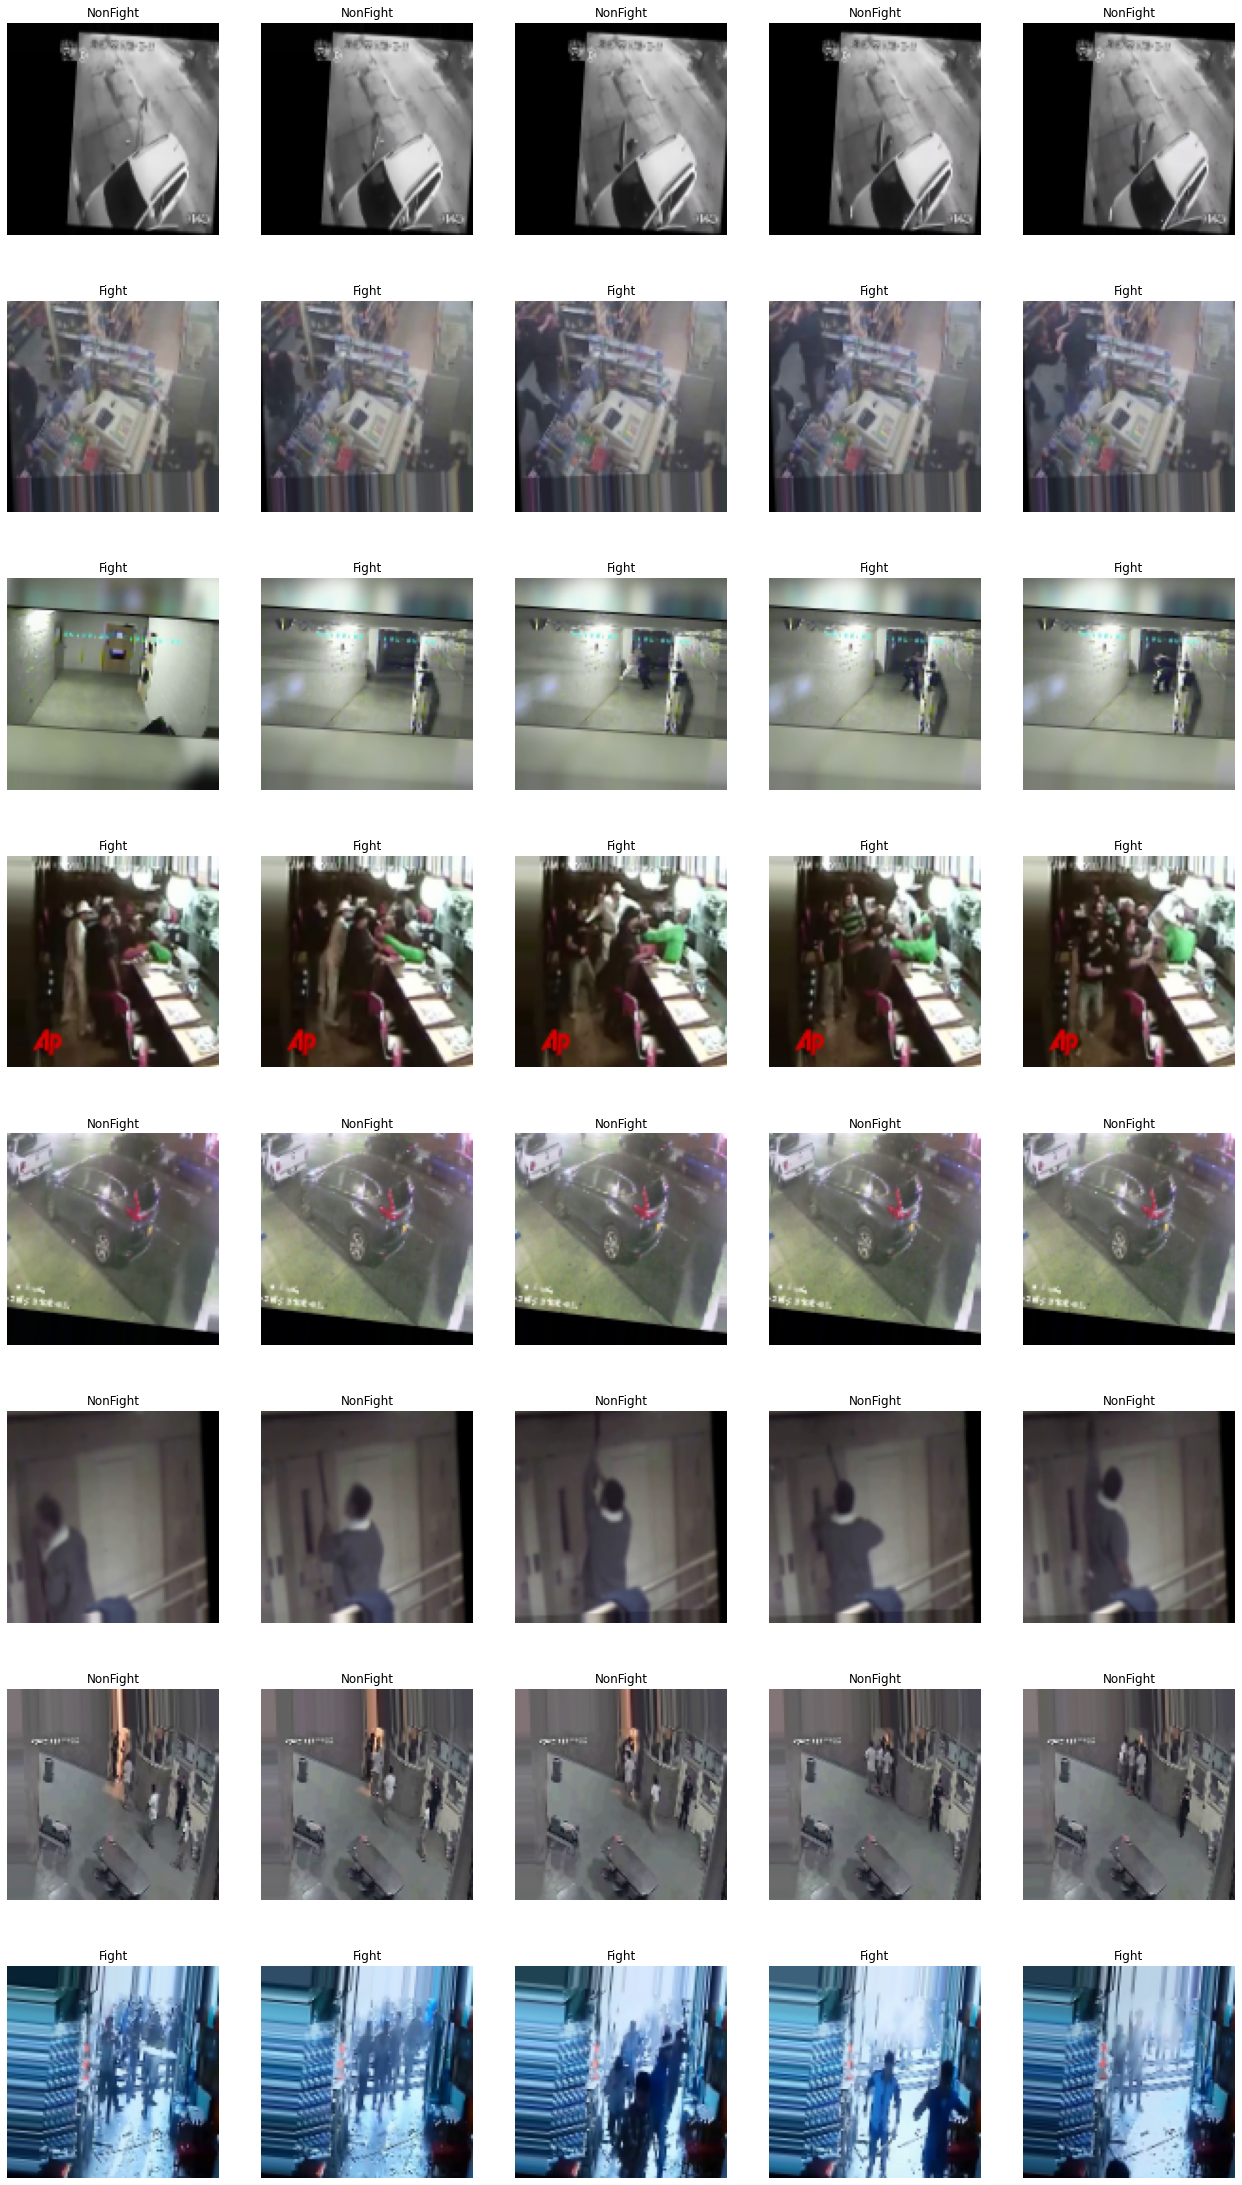

In [7]:
import keras_video.utils
import tensorflow as tf

with tf.device('/device:GPU:0'):
  keras_video.utils.show_sample(train)

In [47]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [48]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [49]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [50]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [38]:
!pip install livelossplot

In [51]:
EPOCHS=50
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras
tqdm_callback = tfa.callbacks.TQDMProgressBar()
callbacks = [
             PlotLossesKeras(),
             tqdm_callback,
             keras.callbacks.ReduceLROnPlateau(verbose=1),
             keras.callbacks.ModelCheckpoint(
                 'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                 verbose=1),
]
with tf.device('/device:GPU:0'):
  history=model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6638 - acc: 0.6250
Epoch 2/50
1/1 [==============================] - 0s 265ms/step - loss: 0.6454 - acc: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 255ms/step - loss: 0.6685 - acc: 0.6250
Epoch 4/50
1/1 [==============================] - 0s 257ms/step - loss: 0.6750 - acc: 0.6250
Epoch 5/50
1/1 [==============================] - 0s 262ms/step - loss: 0.6626 - acc: 0.7500
Epoch 6/50
1/1 [==============================] - 0s 260ms/step - loss: 0.8122 - acc: 0.2500
Epoch 7/50
1/1 [==============================] - 0s 257ms/step - loss: 0.5897 - acc: 0.7500
Epoch 8/50
1/1 [==============================] - 0s 256ms/step - loss: 0.7819 - acc: 0.2500
Epoch 9/50
1/1 [==============================] - 0s 260ms/step - loss: 0.7657 - acc: 0.5000
Epoch 10/50
1/1 [==============================] - 0s 254ms/step - loss: 0.8467 - acc: 0.3750
Epoch 11/50
1/1 [==============================] - 0s 255ms/step - loss:

dict_keys(['loss', 'acc'])


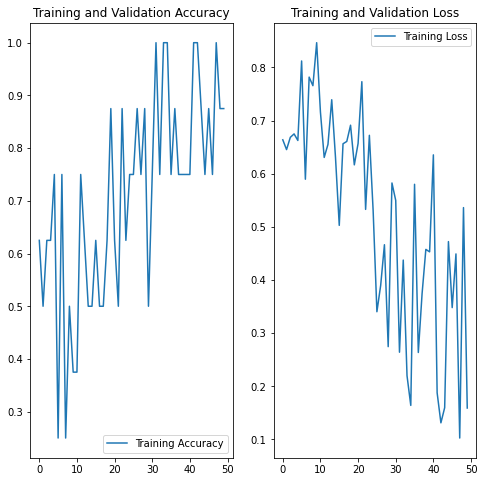

In [52]:
import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()